In [1]:
import os
import numpy as np
import pandas as pd

from functools import reduce

import matplotlib.pyplot as plt
%matplotlib inline

### Introduction

The purpose of this Notebook is to read in other data that I downloaded from the FAO. The processing methods will be similar to the Notebook on [demographic data](https://github.com/Jakidxav/ciat_bean_price_feature_importances/blob/master/notebooks/demographics_eda.ipynb), except here I am analyzing multiple datasets (although still saving them differently in case someone else is only interested in one or several of the processed data sets). Looking at multiple types of variables in one Notebook also has the benefit on cutting down on the total number of them that other people will need to scroll through. Currently, I am analyzing annual food security and land use change data in this Notebook, although this is subject to change if I find other variables that would be interesting to look at.

In [2]:
def load_and_save_paths_fao(type_of_data):
    data_path = '../data/'
    raw = 'raw'
    processed = 'processed'
    
    kenya_name = 'kenya'
    rwanda_name = 'rwanda'
    tanzania_name = 'tanzania'
    uganda_name = 'uganda'
    
    append_in = '_'+type_of_data+'_'+raw+'.csv'
    append_out = '_'+type_of_data+'_'+processed+'.csv'

    #where to load from
    kenya_load = os.path.join(data_path, raw, type_of_data, kenya_name+append_in)
    rwanda_load = os.path.join(data_path, raw, type_of_data, rwanda_name+append_in)
    tanzania_load = os.path.join(data_path, raw, type_of_data, tanzania_name+append_in)
    uganda_load = os.path.join(data_path, raw, type_of_data, uganda_name+append_in)

    #where to save to
    kenya_save = os.path.join(data_path, processed, type_of_data, kenya_name+append_out)
    rwanda_save = os.path.join(data_path, processed, type_of_data, rwanda_name+append_out)
    tanzania_save = os.path.join(data_path, processed, type_of_data, tanzania_name+append_out)
    uganda_save = os.path.join(data_path, processed, type_of_data, uganda_name+append_out)
    
    load = [kenya_load, rwanda_load, tanzania_load, uganda_load]
    save = [kenya_save, rwanda_save, tanzania_save, uganda_save]
    
    return load, save

In [3]:
type_of_data_food = 'food_security'
type_of_data_land = 'land_use'

#load file paths to load/save locations
load_food, save_food = load_and_save_paths_fao(type_of_data_food)
load_land, save_land = load_and_save_paths_fao(type_of_data_land)

#unpack file paths
kenya_load_food, rwanda_load_food, tanzania_load_food, uganda_load_food = load_food
kenya_save_food, rwanda_save_food, tanzania_save_food, uganda_save_food = save_food

kenya_load_land, rwanda_load_land, tanzania_load_land, uganda_load_land = load_land
kenya_save_land, rwanda_save_land, tanzania_save_land, uganda_save_land = save_land

The following method is a bit complicated. Basically, columns exist in some FAO datasets and not others, and not all columns in a given dataset have the same length. In some columns, the unit of measurement is present while in others it isn't. In order to make the method work for multiple datasets, there are several if/else checks to make sure that the column names are correct.

In [4]:
def load_fao_data(path_name, food=False):
    country = pd.read_csv(path_name)
    
    df_list = []
    fao_drop_columns = ['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
                        'Item Code', 'Year Code', 'Unit', 'Flag', 'Flag Description']
    
    #the food data has an extra column that we need to drop
    if food==True:
        fao_drop_columns.append('Note')

    country_data = country.loc[:, 'Item'].unique()

    #returns a dictionary of types of population data
    country_dict = country.groupby('Item').groups

    for key, value in country_dict.items():
        column_data = country.loc[country_dict[key].values, :]
        column_data.reset_index(inplace=True, drop=True)
        column_data.drop(fao_drop_columns, inplace=True, axis=1)
        
        #this is to reset column names and drop extra columns
        if food==True:
            column_data.columns = ['Item', 'Year', column_data.Item[0]]
        else:
            #this is for land data specifically
            column_data.columns = ['Item', 'Year', column_data.Item[0]+' (1000 ha)']
        column_data.drop('Item', axis=1, inplace=True)
        
        #adaptively change years to match the length of the Series, even
        #if there is missing data
        start_year = 2010
        column_data['Year'] = np.arange(start_year, start_year+len(column_data))
    
        if food==True:
            filter_length = 9
        else:
            filter_length = 8
        
        if len(column_data) < filter_length:
            continue
        else:
            #now we need to append months to this column so we can merge it with our other data sets
            column_data['Date-Monthly'] = ['Jun-'+entry[-2:] for entry in column_data['Year'].astype(str)]
            
            #lastly, drop the Year column
            column_data.drop('Year', axis=1, inplace=True)
            
            df_list.append(column_data)

    #source: https://stackoverflow.com/questions/38089010/merge-a-list-of-pandas-dataframes
    processed_data = reduce(lambda x, y: pd.merge(x, y, on=['Date-Monthly']), df_list)
    
    if food==True:
        #unfortunately, uganda does not have data for this column, so we need to drop it
        processed_data.drop('Number of people undernourished (million) (3-year average)', axis=1, inplace=True)
    else:
        #there is a duplicate column in the land use change data for agriculture area
        processed_data.drop(['Agriculture (1000 ha)'], axis=1, inplace=True)
        #and rwanda does not have data for organic agriculture
        if 'Agriculture area under organic agric. (1000 ha)' in processed_data.columns:
            processed_data.drop(['Agriculture area under organic agric. (1000 ha)'], axis=1, inplace=True)
    
    return processed_data

In [5]:
#load food data
kenya_food = load_fao_data(kenya_load_food, True)
rwanda_food = load_fao_data(rwanda_load_food, True)
tanzania_food = load_fao_data(tanzania_load_food, True)
uganda_food = load_fao_data(uganda_load_food, True)

#load land use data
kenya_land = load_fao_data(kenya_load_land)
rwanda_land = load_fao_data(rwanda_load_land)
tanzania_land = load_fao_data(tanzania_load_land)
uganda_land = load_fao_data(uganda_load_land)

In [6]:
kenya_food

,Average dietary energy supply adequacy (percent) (3-year average),Date-Monthly,Political stability and absence of violence/terrorism (index)
0,97.0,Jun-10,-1.17
1,97.0,Jun-11,-1.24
2,98.0,Jun-12,-1.32
3,98.0,Jun-13,-1.17
4,99.0,Jun-14,-1.28
5,98.0,Jun-15,-1.24
6,97.0,Jun-16,-1.35
7,97.0,Jun-17,-1.13
8,97.0,Jun-18,-1.16


In [7]:
kenya_land

,Agricultural land (1000 ha),Date-Monthly,Arable land (1000 ha),Country area (1000 ha),Cropland (1000 ha),Forest land (1000 ha),Land area (1000 ha),Land under permanent crops (1000 ha),Other naturally regenerated forest (1000 ha),Planted Forest (1000 ha),Primary Forest (1000 ha)
0,27320.0,Jun-10,5500.0,58037.0,6020.0,4230.0,56914.0,520.0,4037.0,193.0,0.0
1,27630.0,Jun-11,5800.0,58037.0,6330.0,4266.6,56914.0,530.0,4068.2,198.4,0.0
2,27730.0,Jun-12,5900.0,58037.0,6430.0,4303.2,56914.0,530.0,4099.4,203.8,0.0
3,27630.0,Jun-13,5800.0,58037.0,6330.0,4339.8,56914.0,530.0,4130.6,209.2,0.0
4,27630.0,Jun-14,5800.0,58037.0,6330.0,4376.4,56914.0,530.0,4161.8,214.6,0.0
5,27630.0,Jun-15,5800.0,58037.0,6330.0,4413.0,56914.0,530.0,4193.0,220.0,0.0
6,27630.0,Jun-16,5800.0,58037.0,6330.0,4413.0,56914.0,530.0,4193.0,220.0,0.0
7,27630.0,Jun-17,5800.0,58037.0,6330.0,4413.0,56914.0,530.0,4193.0,220.0,0.0


Notice that the land use data is missing year. We will need to interpolate this value when we merge all of our datasets together.

Next, let's plot some of the output that we got for the countries in our analysis.

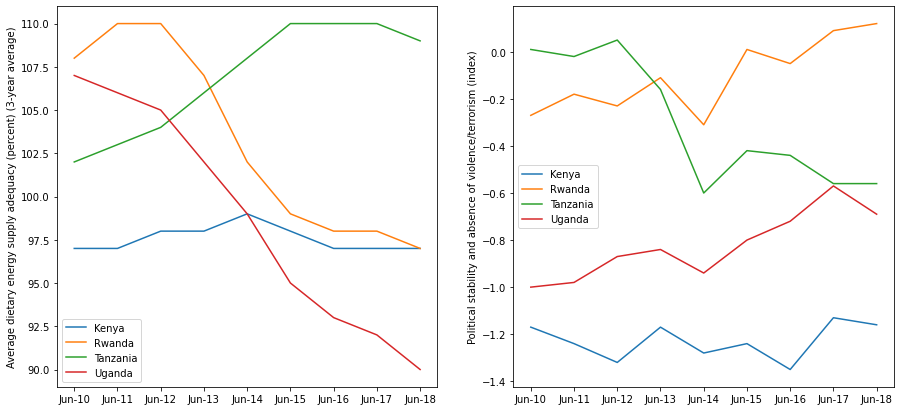

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

#dietary supply adequacy
ax[0].plot(kenya_food['Date-Monthly'], kenya_food['Average dietary energy supply adequacy (percent) (3-year average)'], label='Kenya')
ax[0].plot(rwanda_food['Date-Monthly'], rwanda_food['Average dietary energy supply adequacy (percent) (3-year average)'], label='Rwanda')
ax[0].plot(tanzania_food['Date-Monthly'], tanzania_food['Average dietary energy supply adequacy (percent) (3-year average)'], label='Tanzania')
ax[0].plot(uganda_food['Date-Monthly'], uganda_food['Average dietary energy supply adequacy (percent) (3-year average)'], label='Uganda')
ax[0].set_ylabel('Average dietary energy supply adequacy (percent) (3-year average)')

#political stability
ax[1].plot(kenya_food['Date-Monthly'], kenya_food['Political stability and absence of violence/terrorism (index)'], label='Kenya')
ax[1].plot(rwanda_food['Date-Monthly'], rwanda_food['Political stability and absence of violence/terrorism (index)'], label='Rwanda')
ax[1].plot(tanzania_food['Date-Monthly'], tanzania_food['Political stability and absence of violence/terrorism (index)'], label='Tanzania')
ax[1].plot(uganda_food['Date-Monthly'], uganda_food['Political stability and absence of violence/terrorism (index)'], label='Uganda')
ax[1].set_ylabel('Political stability and absence of violence/terrorism (index)')

ax[0].legend()
ax[1].legend()
plt.show()

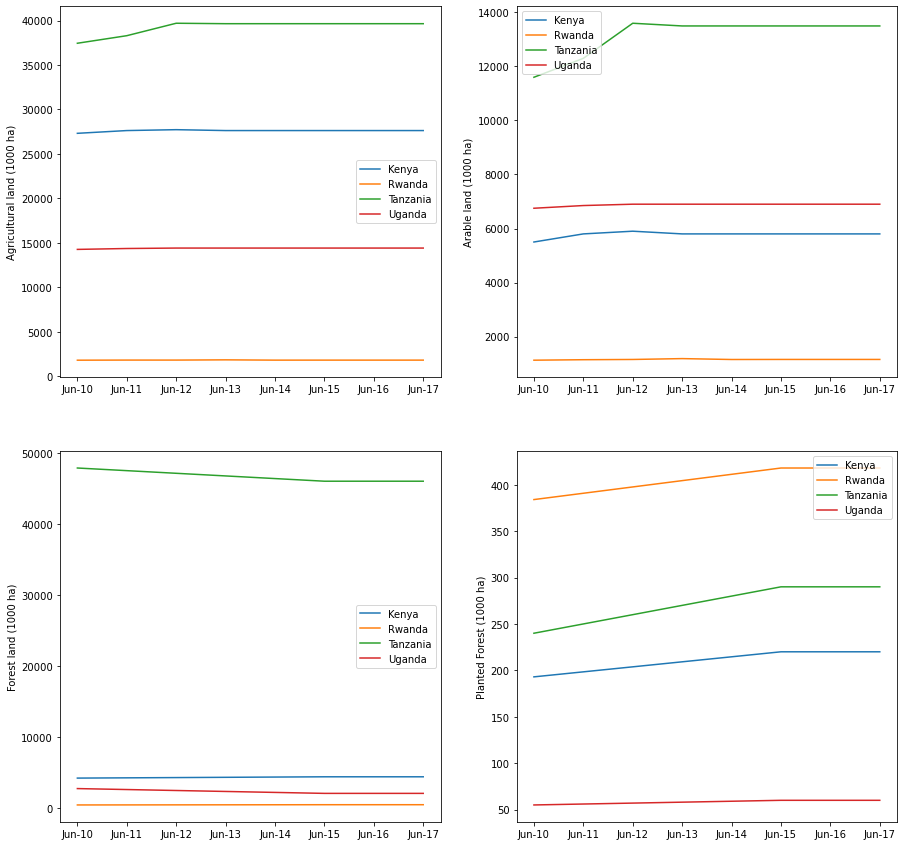

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

country_dfs = [kenya_land, rwanda_land, tanzania_land, uganda_land]
countries = ['Kenya', 'Rwanda', 'Tanzania', 'Uganda']
columns = ['Agricultural land (1000 ha)', 'Arable land (1000 ha)', 'Forest land (1000 ha)', 'Planted Forest (1000 ha)']
i = 0
j = 0

for dataset in country_dfs:
    #i will stay the same, but j will increase to go through country labels
    ax[0, 0].plot(dataset['Date-Monthly'], dataset[columns[i]], label=countries[j])
    ax[0, 1].plot(dataset['Date-Monthly'], dataset[columns[i+1]], label=countries[j])
    ax[1, 0].plot(dataset['Date-Monthly'], dataset[columns[i+2]], label=countries[j])
    ax[1, 1].plot(dataset['Date-Monthly'], dataset[columns[i+3]], label=countries[j])
    j += 1

ax[0, 0].set_ylabel('Agricultural land (1000 ha)')
ax[0, 1].set_ylabel('Arable land (1000 ha)')
ax[1, 0].set_ylabel('Forest land (1000 ha)')
ax[1, 1].set_ylabel('Planted Forest (1000 ha)')

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
plt.show()

So the land-use change data doesn't contain much variability, so a ML model most likely won't learn much from it. However, it is worth including because Random Forests (or tree-based models in general) aren't really affected by outlier variables.

In [10]:
#now save data
# kenya_food.to_csv(kenya_save_food)
# rwanda_food.to_csv(rwanda_save_food)
# tanzania_food.to_csv(tanzania_save_food)
# uganda_food.to_csv(uganda_save_food)

# kenya_land.to_csv(kenya_save_land)
# rwanda_land.to_csv(rwanda_save_land)
# tanzania_land.to_csv(tanzania_save_land)
# uganda_land.to_csv(uganda_save_land)